In [339]:
# Sentiment Analysis in Code-Mixed Telugu-English Text with Unsupervised Data Normalization

In [340]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [341]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import load_metric

import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [342]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### **Import data and Pre-Processing**

In [343]:
# menghilangkan format html
html_tag = re.compile(r'<.*?>')
# menghilangkan format URL
http_link = re.compile(r'https://\S+')
www_link = re.compile(r'www\.\S+')
# menghilangkan tanda baca
punct = re.compile(r"[^\w\s]")
# menghilangkan angka
number = re.compile(r"\d")
# menghilangkan double spasi
# space = re.compile(r"\s\s+")

def clean_data(text):
    text = re.sub(html_tag, r" ", text)
    text = re.sub(http_link, r" ", text)
    text = re.sub(www_link, r" ", text)
    text = re.sub(punct, r" ", text)
    text = re.sub(number, r" ", text)
    # text = re.sub(space, r" ", text)
    return text

In [344]:
df = pd.read_csv("Indonesian_English_CodeMixed_stemV3.csv", sep=",", encoding='cp1252')
df = df[["sentiment_label", "clean_text"]]

df['text_clean'] = df['clean_text'].apply(lambda x: clean_data(x))
df.head()

,sentiment_label,clean_text,text_clean
0,negative,not habits.. tekanan,not habits tekanan
1,positive,first love ku di dunia fangirl sih 1D sama 5so...,first love ku di dunia fangirl sih D sama so...
2,positive,"handcream jp 110k , photo set carland 30k , tc...",handcream jp k photo set carland k tc...
3,positive,Apa bedanya donut sama doughtnut?,Apa bedanya donut sama doughtnut
4,positive,"Baik kakak, akan kami bantu respond via direct...",Baik kakak akan kami bantu respond via direct...


In [345]:
list_lower = ['text_clean']

for i in list_lower:
  df[i] = df[i].apply(lambda x: x.lower())

df.head()

,sentiment_label,clean_text,text_clean
0,negative,not habits.. tekanan,not habits tekanan
1,positive,first love ku di dunia fangirl sih 1D sama 5so...,first love ku di dunia fangirl sih d sama so...
2,positive,"handcream jp 110k , photo set carland 30k , tc...",handcream jp k photo set carland k tc...
3,positive,Apa bedanya donut sama doughtnut?,apa bedanya donut sama doughtnut
4,positive,"Baik kakak, akan kami bantu respond via direct...",baik kakak akan kami bantu respond via direct...


In [346]:
df = df[["text_clean", "sentiment_label"]]
df.rename(columns={"text_clean": "text", "sentiment_label": "label"}, inplace=True)

# df['label'] = df['label'].replace('neutral', 0)
# df['label'] = df['label'].replace('positive', 1)
# df['label'] = df['label'].replace('negative', 2)

# df['label'] = df['label'].replace('neutral', 1)
# df['label'] = df['label'].replace('positive', 2)
# df['label'] = df['label'].replace('negative', 0)

df['label'] = df['label'].replace('positive', 1)
df['label'] = df['label'].replace('negative', 0)

df['label'] = df['label'].astype('int')
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)

df = df[['text', 'label']]
df.sample(5)

,text,label
70,sa kamu kan jutek sama orang baru you know ...,0
827,laki kalo udah ketauan salah emang suka banget...,0
231,kebal hukum not fair bisa kah hal ini di...,0
588,well sudah berusaha meskipun banyak bola out...,1
39,inside not ready for usbn unbk utbk simak ut...,0


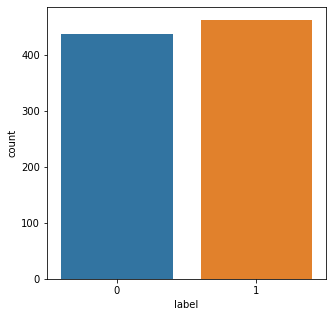

In [347]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df['label'])
plt.show()

In [348]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED,
)

In [349]:
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

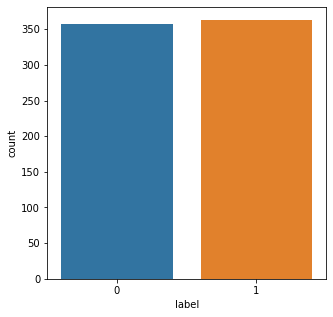

In [350]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_train['label'])
plt.show()

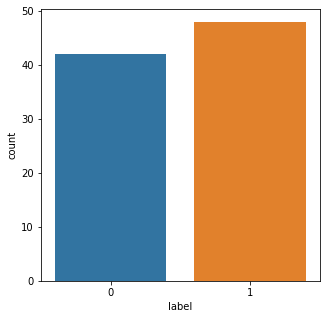

In [351]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_val['label'])
plt.show()

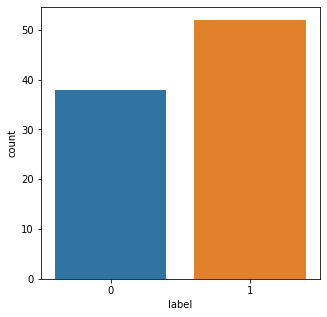

In [352]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df_test['label'])
plt.show()

In [353]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 720
Total Val  : 90
Total Test : 90


In [354]:
actual_label = df_test['label']

In [355]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [356]:
from datasets import load_dataset

files = {
    "train": "train.csv", 
    "eval": "eval.csv", 
    "test": "test.csv",
}

dataset = load_dataset('csv', data_files=files)


Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b07871e30461ba4a/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### **Tokenize Model**

In [357]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased", num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size":

In [358]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [359]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

### **Train Model**

In [360]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [361]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size":

In [362]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "test_trainer", 
    per_device_train_batch_size=16,
    num_train_epochs = 7.0,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [363]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 720
  Num Epochs = 7
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 315
  Number of trainable parameters = 177854978


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




### **Evaluate Model**

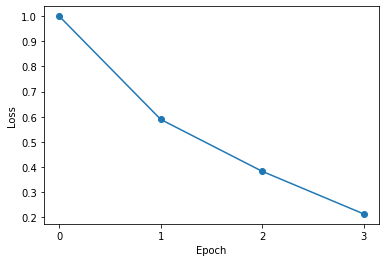

In [364]:
plt.plot([1, 0.5891, 0.3825, 0.2129], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0, 1, 2, 3])
plt.show()

In [365]:
evaluation_history = trainer.evaluate()
evaluation_history

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 90
  Batch size = 8


{'eval_loss': 1.9583221673965454,
 'eval_accuracy': 0.6222222222222222,
 'eval_runtime': 1.3957,
 'eval_samples_per_second': 64.483,
 'eval_steps_per_second': 8.598,
 'epoch': 7.0}

In [366]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 90
  Batch size = 8


In [367]:
print(classification_report(prediction, actual_label, target_names=["Negatif", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.66      0.74      0.69        34
     Positif       0.83      0.77      0.80        56

    accuracy                           0.76        90
   macro avg       0.74      0.75      0.75        90
weighted avg       0.76      0.76      0.76        90



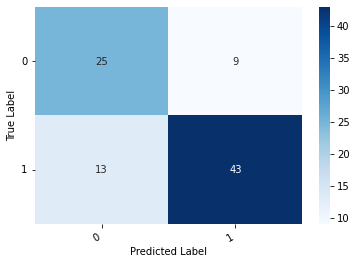

In [368]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

In [369]:
data = pd.DataFrame()
data = df_test
data["prediction_data"] = prediction
data.rename(columns={"text_clean": "text", "label": "actual_data"}, inplace=True)
data

,text,actual_data,prediction_data
67,interstellar paling recommended sih the marti...,1,1
370,israel air strike on syria kills seven people,0,0
518,in the arthmetic of love one plus one equals ...,1,1
60,our favourite vice president nominees respect ...,1,1
275,ada lagi preview nya do not know who but kekn...,1,1
...,...,...,...
208,yang vidioin yang di cari yang beberkan bukti...,0,0
652,semenjak ditelpon contact center telkomsel bua...,0,0
440,tiba tiba dia masuk lagi dan ngomong kaya...,1,1
658,well same here hehe kadang suka begitu,1,1


In [370]:
data['actual_data'].equals(data['prediction_data'])

False

In [371]:
data['result'] = np.where((data['actual_data'] == data['prediction_data']), data['actual_data'], "false")
data

,text,actual_data,prediction_data,result
67,interstellar paling recommended sih the marti...,1,1,1
370,israel air strike on syria kills seven people,0,0,0
518,in the arthmetic of love one plus one equals ...,1,1,1
60,our favourite vice president nominees respect ...,1,1,1
275,ada lagi preview nya do not know who but kekn...,1,1,1
...,...,...,...,...
208,yang vidioin yang di cari yang beberkan bukti...,0,0,0
652,semenjak ditelpon contact center telkomsel bua...,0,0,0
440,tiba tiba dia masuk lagi dan ngomong kaya...,1,1,1
658,well same here hehe kadang suka begitu,1,1,1


In [372]:
data.to_csv("result.csv", index=False)

### **Save And Load Model**

In [373]:
model.save_pretrained("model")

Configuration saved in model/config.json
Model weights saved in model/pytorch_model.bin


In [374]:
model = AutoModelForSequenceClassification.from_pretrained("model")

loading configuration file model/config.json
Model config BertConfig {
  "_name_or_path": "model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

loading weights file model/pytorch_model.bin
All model che

In [375]:
trainer = Trainer(model=model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [376]:
def predict(text):
    tokenized = tokenizer(text, padding='max_length', max_length=256)
    label = trainer.predict([tokenized]).predictions.argmax(1)[0]
    if label == 0:
        print(f'Predicted: Negatif [{label}]')
    # elif label == 1:
    #     print(f'Predicted: Netral [{label}]')
    else:
        print(f'Predicted: Positif [{label}]')

In [377]:
predict("well, sudah bagus")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Positif [1]


In [378]:
predict("semangat terus, keep the spirit boy")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Positif [1]


In [379]:
predict("ya i used to be like that but i learned that selama orang itu gak minta diperbaiki ya no need to be rude sih hehe takutnya tersinggung nah ini yang bener malah sok dibenerin kan gondok saya")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Negatif [0]


In [380]:
predict("well, dia siapa ya?")

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


Predicted: Positif [1]
